In [1]:
import pyfftw 
import modemc
import numpy as np
import matplotlib.pyplot as plt
import datetime, pickle, tempfile, time, sys, os
from helpers.sim_helper import *
from helpers import plotting
from IPython.display import clear_output

## 1. Parameters

In [2]:
simulation_name = 'inst_switch'
use_temp_folder = False
run_name = 'notebook'
run_info = run_name
ssh_comp = 'notebook'

In [3]:
use_default_params = True

In [4]:
# Load arguments if running as a script
if sys.argv[1] == "args":
    use_default_params = False
    
    use_temp_folder = False
    params_pkl_path = sys.argv[2]
    args_params = pickle.load(open(params_pkl_path, 'rb'))

    for param_k, param_v in args_params.items():
        globals()[param_k] = param_v

### System

In [5]:
if use_default_params:
    system_params = {
        'beta' : 100,
        'gamma' : 5,
        'Tf' : 3.5,

        'dim' : 2,

        'x0' : np.array([-1, 0]),
        'x1' : np.array([1, 0]),

        'U0' : 3,
        'xi1' : 0,
        'xi2' : 2,
    }

system = modemc.systems.Switch(system_params)
dict_to_global(system_params, globals())

In [6]:
if use_default_params:
    Q_params = {
        'Q_Nm_Tf_factor' : 10,
        'Q_band_size_Nm_Tf_factor' : 20,
        'Q_Nq_factor' : 12,
        'Q_quad_scheme' : modemc.quad.clenshaw_curtis,
        'N_instanton_loops' : 0,
    }

Q_params['Q_band_size'] = int(np.round(system_params['Tf'] * Q_params['Q_band_size_Nm_Tf_factor']))
    
dict_to_global(Q_params, globals())

### Calibration

In [7]:
if use_default_params:
    instanton_finder_params = {
        'instanton_finder_Nm_Tf_factor' : 60,
        'instanton_finder_Nq_factor' : 12,
        'max_steps' : int(1e6),
        'ag_c' : 1e-6,
        'S_tol' : 1e-20,
        'gradS_tol' : 1e-6,
        'step_size0' : 0.1,
        'step_size_rate' : 0.99,
        'min_step_size' : 1e-60,
        'quad_scheme' : modemc.quad.clenshaw_curtis,
        'GY_dt' : 1e-3,
        'GY_dps' : 1000,
        'verbose' : True,
    }

instanton_finder_params['system'] = system
instanton_finder_params['Nm'] = int(np.round(instanton_finder_params['instanton_finder_Nm_Tf_factor'] * system_params['Tf']))
instanton_finder_params['Nq'] = int(np.round(instanton_finder_params['instanton_finder_Nq_factor'] * instanton_finder_params['Nm']))
    
dict_to_global(instanton_finder_params, globals(), prefix='instanton_finder')

### Plotting

In [8]:
if use_default_params:
    plotting_params = {
        'xlims' : [-1.3, 1.3],
        'ylims' : [-1.3, 1.3],
        'tlims_offset' : [-0.1, 0.1],

        'upper_OM_inst_color' : "red",
        'upper_OM_inst_shape' : "-",
        'lower_OM_inst_color' : "orangered",
        'lower_OM_inst_shape' : "--",
        'middle_OM_inst_color' : "yellow",
        'middle_OM_inst_shape' : ":",
        'upper_FW_inst_color' : "blue",
        'upper_FW_inst_shape' : "-",
        'lower_FW_inst_color' : "teal",
        'lower_FW_inst_shape' : "--",
        'middle_FW_inst_color' : "green",
        'middle_FW_inst_shape' : ":",
    }

plotting_params['tlims'] = [0 + plotting_params['tlims_offset'][0], Tf + plotting_params['tlims_offset'][1]]
    
dict_to_global(plotting_params, globals(), deal_with_overwrites=True)

### Setup

In [9]:
results = {} # For storing any intermediate calibration results or larger results, like instantons
calcs = {} # For observables and other calculations
sim_states = {} # For storing things like simulation time, teleportation success rates etc

In [10]:
params_to_not_include = ['dim', 'x0', 'x1']
parameters_to_include_in_name = { k:v for (k,v) in system_params.items() if not k in params_to_not_include }
parameters_to_include_in_name['beta'] = '{:.2e}'.format(beta)
parameters_to_include_in_name['Nm_Tf_factor'] = instanton_finder_instanton_finder_Nm_Tf_factor

sim_result = SimResult(simulation_name, run_name, run_info, parameters_to_include_in_name, use_temp_folder, ssh_comp)
sim_result.save_note('UNFINISHED', str(datetime.datetime.now()))
sys.excepthook = sim_result.crash_log

if sys.argv[1] == "args":
    sim_result.save_pkl('args_params', args_params)

Result name: [notebook] inst_switch, beta=1.00e+02, gamma=5, Tf=3.50e+00, U0=3, xi1=0, xi2=2, Nm_Tf_factor=60 (21-11-30, 00:44:31)

In progress folder:
output/in_progress/inst_switch/notebook/[notebook] inst_switch, beta=1.00e+02, gamma=5, Tf=3.50e+00, U0=3, xi1=0, xi2=2, Nm_Tf_factor=60 (21-11-30, 00:44:31)

Output folder:
output/inst_switch/notebook/[notebook] inst_switch, beta=1.00e+02, gamma=5, Tf=3.50e+00, U0=3, xi1=0, xi2=2, Nm_Tf_factor=60 (21-11-30, 00:44:31)



In [11]:
results = {} # For storing any intermediate calibration results or larger results, like instantons
calcs = {} # For observables and other calculations
sim_states = {} # For storing things like simulation time, teleportation success rates etc

In [12]:
sim_result.log('SSH comp: %s' % ssh_comp, print_time=False)

SSH comp: notebook


In [13]:
sim_result.log('Params:')
for k,v in parameters_to_include_in_name.items():
    sim_result.log(' %s = %s' % (k,v), print_time=False)
sim_result.log('', print_time=False)

Params:
 beta = 1.00e+02
 gamma = 5
 Tf = 3.5
 U0 = 3
 xi1 = 0
 xi2 = 2
 Nm_Tf_factor = 60



In [14]:
if True:
    os.environ['OPENBLAS_NUM_THREADS'] = '1'
    os.environ['MKL_NUM_THREADS'] = '1'
    os.environ["NUMEXPR_NUM_THREADS"] = '1'
    os.environ["OMP_NUM_THREADS"] = '1'
    pyfftw.config.NUM_THREADS = 1

## 2. Calibration

### Find instanton

In [15]:
def filter_valid_paths(found_instantons, test_upper, clockwise_loops, Qf, use_OM):
    if type(found_instantons) != list:
        found_instantons = [found_instantons]
    
    valid_instantons = []
    invalid_instantons = []
    for inst in found_instantons:
        eigs = np.linalg.eigvalsh(Qf)
        Qf_det_sign, Qf_det = np.linalg.slogdet(Qf)
        
        is_valid = np.count_nonzero(eigs[eigs<0]) == 0
        is_valid = is_valid and (Qf_det_sign == 1)
        
        winding_number = compute_path_winding_number(inst['path'], inst['d_path'], inst['ts'])
        
        if test_upper:
            is_valid = is_valid and (winding_number == -(0.5+clockwise_loops))
        else:
            is_valid = is_valid and (winding_number == -(-0.5+clockwise_loops))
        
        #if test_upper:
        #    # Reaches the upper channel boundary
        #    is_valid = is_valid and np.count_nonzero(inst['path'][1,:] > analysis_params['valid_path_channel_boundary']) > 0
        #    # Never reaches the lower channel boundary
        #    is_valid = is_valid and np.count_nonzero(inst['path'][1,:] < -analysis_params['valid_path_channel_boundary']) == 0
        #else:
        #    # Reaches the lower channel boundary
        #    is_valid = is_valid and np.count_nonzero(inst['path'][1,:] > -analysis_params['valid_path_channel_boundary']) > 0
        #    # Never reaches the upper channel boundary
        #    is_valid = is_valid and np.count_nonzero(inst['path'][1,:] > analysis_params['valid_path_channel_boundary']) == 0
        
        inst['is_valid'] = is_valid
            
        if is_valid:
            valid_instantons.append( inst )
        else:
            invalid_instantons.append( inst )
            
    if len(valid_instantons) > 0:
        return valid_instantons
    else:
        return invalid_instantons # If no valid path is found, just return the invalid ones

In [16]:
def compute_path_winding_number(path, d_path, ts):
    path_r2s = path[0,:]**2 + path[1,:]**2
    dthetas = (path[0,:]*d_path[1,:] - path[1,:]*d_path[0,:]) / path_r2s # (x dy - y dx)/r^2
    dthetas /= (2 * np.pi)
    winding_number = np.round(2*np.trapz(dthetas, x=ts))/2
    return winding_number

def find_instanton(find_upper, clockwise_loops, use_OM):
    basis_us = np.linspace(-1, 1, 50000)
    basis_ts = Tf*(basis_us+1)/2
    basis = modemc.utils.get_brownian_bridge_KL_basis(instanton_finder_params['Nm'], dim, basis_ts)
    
    if find_upper:
        inst_path0 = np.array([-np.cos(np.pi*(1 + 2*clockwise_loops)*basis_ts/Tf), np.sin(np.pi*(1 + 2*clockwise_loops)*basis_ts/Tf)])
    else:
        inst_path0 = np.array([-np.cos(np.pi*(1 + 2*clockwise_loops)*basis_ts/Tf), -np.sin(np.pi*(1 + 2*clockwise_loops)*basis_ts/Tf)])
    inst_state0 = modemc.utils.project_onto_basis(inst_path0, basis, basis_ts)
    
    params = dict.copy(instanton_finder_params)
    del params['Nm']
    del params['instanton_finder_Nm_Tf_factor']
    del params['instanton_finder_Nq_factor']
    del params['GY_dps']
    del params['GY_dt']
    params['state0'] = inst_state0
    params['use_OM'] = use_OM
    inst = modemc.instantons.gradient_descent(**params)
    
    Q_Nm = int(np.round(Q_Nm_Tf_factor * Tf))
    inst['Q_OM'], inst['Qf_OM'], _, _, _ = modemc.variations.compute_banded_Q_matrix(system, inst['state'],
                        Q_band_size, Nm=Q_Nm, Nq_factor=Q_Nq_factor, quad_scheme=Q_quad_scheme, return_partial_Qs=True, use_OM=True)
    
    inst['Q_FW'], inst['Qf_FW'], _, _, _ = modemc.variations.compute_banded_Q_matrix(system, inst['state'],
                        Q_band_size, Nm=Q_Nm, Nq_factor=Q_Nq_factor, quad_scheme=Q_quad_scheme, return_partial_Qs=True, use_OM=False)
    
    if use_OM:
        test_Qf = inst['Qf_OM']
    else:
        test_Qf = inst['Qf_FW']
        
    filtered_paths = filter_valid_paths(inst, find_upper, clockwise_loops, test_Qf, use_OM)
    inst = filtered_paths[0]
    
    tele_inst = inst['state'][:, :min(inst['state'].shape[1], Q_Nm)]
    
    t = modemc.protocols.GaussianTeleporter(tele_inst, inst['Qf_OM'], match_precision_Nm=True)
    inst['Z_sign_OM'], inst['log_Z_OM'] = t.Z_sign, t.log_Z
    t = modemc.protocols.GaussianTeleporter(tele_inst, inst['Qf_FW'], match_precision_Nm=True)
    inst['Z_sign_FW'], inst['log_Z_FW'] = t.Z_sign, t.log_Z
    del t
    del inst['Q_OM']
    del inst['Qf_OM']
    del inst['Q_FW']
    del inst['Qf_FW']
    
    return inst

In [17]:
upper_OMs = []
lower_OMs = []
upper_FWs = []
lower_FWs = []

for l in range(N_instanton_loops+1):
    sim_result.log('Loop %s:' % l)
    
    sim_result.log('\tFinding upper OM instanton')
    upper_OMs.append(find_instanton(find_upper=True, clockwise_loops=l, use_OM=True))

    sim_result.log('\tFinding lower OM instanton')
    lower_OMs.append(find_instanton(find_upper=False, clockwise_loops=l, use_OM=True))
    
    sim_result.log('', print_time=False)

sim_result.log('Finding upper FW instanton')
upper_FWs.append(find_instanton(find_upper=True, clockwise_loops=0, use_OM=False))

sim_result.log('Finding lower FW instanton')
lower_FWs.append(find_instanton(find_upper=False, clockwise_loops=0, use_OM=False))

Loop 0:
	Finding upper OM instanton
Instanton finder ended (reason: S_tol): i=5.8500e+02	step_size=5.95e-05	|gradS|=8.70e-05	dS=0.00e+00	S=3.335838e+02
	Finding lower OM instanton
Instanton finder ended (reason: gradS_tol): i=8.3000e+01	step_size=4.91e-04	|gradS|=2.01e-05	dS=0.00e+00	S=3.310757e+02

Finding upper FW instanton
Instanton finder ended (reason: S_tol): i=4.6700e+02	step_size=3.48e-10	|gradS|=9.28e-05	dS=0.00e+00	S=3.494685e+02
Finding lower FW instanton
Instanton finder ended (reason: gradS_tol): i=7.7000e+01	step_size=5.71e-04	|gradS|=2.03e-05	dS=0.00e+00	S=3.385766e+02


In [18]:
upper_OM = upper_OMs[0]
lower_OM = lower_OMs[0]
upper_FW = upper_FWs[0]
lower_FW = lower_FWs[0]

results['upper_OM_instanton'] = upper_OM
results['lower_OM_instanton'] = lower_OM
results['upper_FW_instanton'] = upper_FW
results['lower_FW_instanton'] = lower_FW

results['upper_OM_loop_instantons'] = upper_OMs
results['lower_OM_loop_instantons'] = lower_OMs
results['upper_FW_loop_instantons'] = upper_FWs
results['lower_FW_loop_instantons'] = lower_FWs

In [19]:
for l in range(N_instanton_loops+1):
    sim_result.log('Upper OM loop %s valid = %s' % (l, upper_OMs[l]['is_valid']), print_time=False)
    sim_result.log('Lower OM loop %s valid = %s' % (l, lower_OMs[l]['is_valid']), print_time=False)

Upper OM loop 0 valid = True
Lower OM loop 0 valid = True


Compute Gelfand-Yaglom determinants

In [20]:
for i, inst in enumerate(upper_OMs+lower_OMs+upper_FWs+lower_FWs):
    sim_result.log('Gelfand-Yaglom %s/%s' % (i+1, len(upper_OMs+lower_OMs+upper_FWs+lower_FWs)))
    inst['GY_Q_sign_OM'], inst['GY_log_det_Q_OM'], inst['GY_Y_OM'] = modemc.variations.compute_gelfand_yaglom_determinant(instanton_finder_GY_dt, system, inst['state'], use_OM=True, mpmath_dps=instanton_finder_GY_dps)
    inst['GY_Q_sign_FW'], inst['GY_log_det_Q_FW'], inst['GY_Y_FW'] = modemc.variations.compute_gelfand_yaglom_determinant(instanton_finder_GY_dt, system, inst['state'], use_OM=False, mpmath_dps=instanton_finder_GY_dps)
    inst['GY_log_Z_OM'] = -0.5*inst['GY_log_det_Q_OM']
    inst['GY_log_Z_FW'] = -0.5*inst['GY_log_det_Q_FW']

Gelfand-Yaglom 1/4
Gelfand-Yaglom 2/4
Gelfand-Yaglom 3/4
Gelfand-Yaglom 4/4


## 5. Analysis

In [21]:
def compute_semi_analytical_channel_rate(upper_inst, lower_inst, use_OM, use_GY):
    if use_OM:
        postfix = 'OM'
    else:
        postfix = 'FW'
        
    if use_GY:
        prefix = 'GY_'
    else:
        prefix = ''
    
    if upper_inst['is_valid'] and lower_inst['is_valid']:
        dS = upper_inst['S'] - lower_inst['S']
        dQ = lower_inst['%slog_Z_%s' % (prefix, postfix)] - upper_inst['%slog_Z_%s' % (prefix, postfix)]
        Q_channel_rate = 1 / (1 + np.exp(dQ+dS))
        inst_channel_rate = 1 / (1 + np.exp(dS))
    elif not upper_inst['is_valid'] or not lower_inst['is_valid']:
        Q_channel_rate = np.nan
        inst_channel_rate = np.nan
        
    return Q_channel_rate, inst_channel_rate

calcs['IOM_QOM_channel_rate'], calcs['IOM_channel_rate'] = compute_semi_analytical_channel_rate(upper_OM, lower_OM, use_OM=True, use_GY=False)
calcs['IOM_QFW_channel_rate'], calcs['IOM_channel_rate'] = compute_semi_analytical_channel_rate(upper_OM, lower_OM, use_OM=False, use_GY=False)
calcs['IFW_QOM_channel_rate'], calcs['IFW_channel_rate'] = compute_semi_analytical_channel_rate(upper_FW, lower_FW, use_OM=True, use_GY=False)
calcs['IFW_QFW_channel_rate'], calcs['IFW_channel_rate'] = compute_semi_analytical_channel_rate(upper_FW, lower_FW, use_OM=False, use_GY=False)
calcs['GY_IOM_QOM_channel_rate'], _ = compute_semi_analytical_channel_rate(upper_OM, lower_OM, use_OM=True, use_GY=True)
calcs['GY_IOM_QFW_channel_rate'], _ = compute_semi_analytical_channel_rate(upper_OM, lower_OM, use_OM=False, use_GY=True)
calcs['GY_IFW_QOM_channel_rate'], _ = compute_semi_analytical_channel_rate(upper_FW, lower_FW, use_OM=True, use_GY=True)
calcs['GY_IFW_QFW_channel_rate'], _ = compute_semi_analytical_channel_rate(upper_FW, lower_FW, use_OM=False, use_GY=True)

In [22]:
for k, v in calcs.items():
    sim_result.log('%s: %s' % (k, v), log_name='calcs', print_time=False)

IOM_QOM_channel_rate: 4.534433915927391e-05
IOM_channel_rate: 0.0752925915901335
IOM_QFW_channel_rate: 4.2516781718596414e-05
IFW_QOM_channel_rate: 1.1742907844805487e-08
IFW_channel_rate: 1.8608272766589384e-05
IFW_QFW_channel_rate: 1.0908768786781466e-08
GY_IOM_QOM_channel_rate: 1.5371327507040163e-05
GY_IOM_QFW_channel_rate: 1.436543884927463e-05
GY_IFW_QOM_channel_rate: 4.0583345931068084e-09
GY_IFW_QFW_channel_rate: 3.757633205957683e-09


## 6. Plots

In [23]:
states, paths, actions, accepts = sim_result.load_random_sample(1.0, ['states', 'paths', 'actions', 'accepts'])

Saving figure instplot


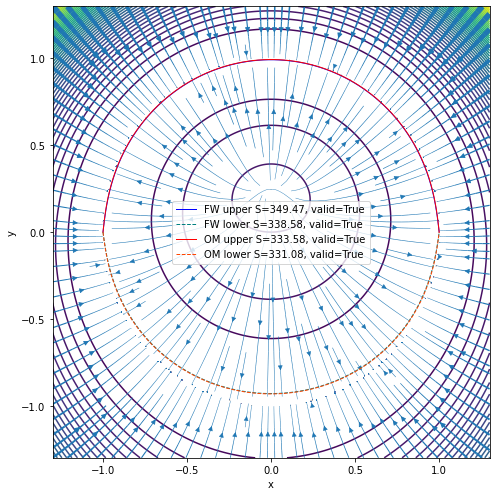

In [24]:
try:
    fig, ax = plt.subplots(figsize=(7,7))
    plotting.trajectories_2D(fig, system, np.zeros((0, dim, 0)), xlims, ylims, plot_num=0, plot_potential=True, plot_force=True,
                        contour_levels=50, force_density=[2,2], traj_lw=0, traj_alpha=0, overlay_paths=[
        ("FW upper S=%s, valid=%s" % (np.round(upper_FW['S'],2), upper_FW['is_valid']), upper_FW_inst_shape, upper_FW_inst_color, upper_FW['state']),
        ("FW lower S=%s, valid=%s" % (np.round(lower_FW['S'],2), lower_FW['is_valid']), lower_FW_inst_shape, lower_FW_inst_color, lower_FW['state']),       
        ("OM upper S=%s, valid=%s" % (np.round(upper_OM['S'],2), upper_OM['is_valid']), upper_OM_inst_shape, upper_OM_inst_color, upper_OM['state']),
        ("OM lower S=%s, valid=%s" % (np.round(lower_OM['S'],2), lower_OM['is_valid']), lower_OM_inst_shape, lower_OM_inst_color, lower_OM['state']),
    ])
    #fig.suptitle(sim_result.result_name)
    plt.legend(loc='center')
    plt.tight_layout()
    sim_result.save_figure(fig, 'instplot', dpi=200)
    plt.show()
except Exception as e:
    sim_result.log_error('instplot', e)

Saving figure upper_OM_loop_0


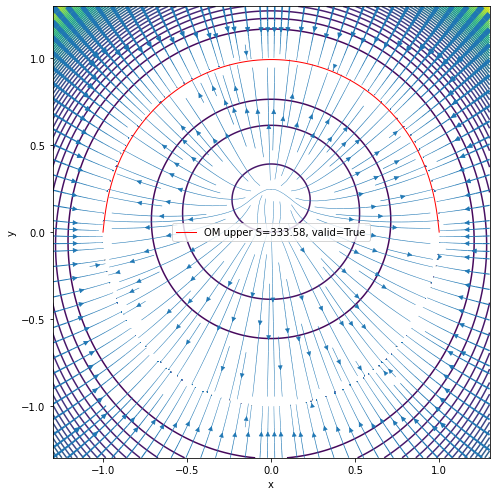

Saving figure lower_OM_loop_0


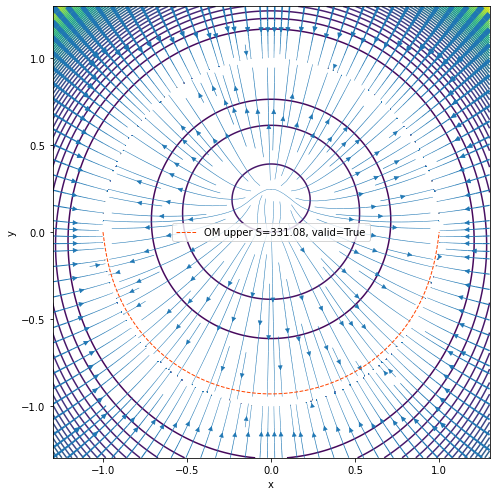

In [25]:
for l in range(N_instanton_loops + 1):

    try:
        inst = upper_OMs[l]
        
        fig, ax = plt.subplots(figsize=(7,7))
        plotting.trajectories_2D(fig, system, np.zeros((0, dim, 0)), xlims, ylims, plot_num=0, plot_potential=True, plot_force=True,
                            contour_levels=50, force_density=[2,2], traj_lw=0, traj_alpha=0, overlay_paths=[
            ("OM upper S=%s, valid=%s" % (np.round(inst['S'],2), inst['is_valid']), upper_OM_inst_shape, upper_OM_inst_color, inst['state']),
        ])
        #fig.suptitle(sim_result.result_name)
        plt.legend(loc='center')
        plt.tight_layout()
        sim_result.save_figure(fig, 'upper_OM_loop_%s' % l, dpi=200)
        plt.show()
    except Exception as e:
        sim_result.log_error('upper_OM_loop_%s' % l, e)
        
        
    try:
        inst = lower_OMs[l]
        
        fig, ax = plt.subplots(figsize=(7,7))
        plotting.trajectories_2D(fig, system, np.zeros((0, dim, 0)), xlims, ylims, plot_num=0, plot_potential=True, plot_force=True,
                            contour_levels=50, force_density=[2,2], traj_lw=0, traj_alpha=0, overlay_paths=[
            ("OM upper S=%s, valid=%s" % (np.round(inst['S'],2), inst['is_valid']), lower_OM_inst_shape, lower_OM_inst_color, inst['state']),
        ])
        #fig.suptitle(sim_result.result_name)
        plt.legend(loc='center')
        plt.tight_layout()
        sim_result.save_figure(fig, 'lower_OM_loop_%s' % l, dpi=200)
        plt.show()
    except Exception as e:
        sim_result.log_error('lower_OM_loop_%s' % l, e)

In [26]:
#try:
#    fig, axes = plotting.plot_time_series_rms(intermediate_expected_observables)
#    plt.tight_layout()
#    sim_result.save_figure(fig, 'intermediate_expected_observables_rms')
#    fig.show()
#except Exception as e:
#    sim_result.log_error('intermediate_expected_observables_rms', e)

In [27]:
#try:
#    fig, axes = plotting.plot_time_series_rms_window(intermediate_expected_observables, intermediate_observables_rms_window)
#    plt.tight_layout()
#    sim_result.save_figure(fig, 'intermediate_expected_observables_rms_window')
#    fig.show()
#except Exception as e:
#    sim_result.log_error('intermediate_expected_observables_rms_window', e)

In [28]:
sim_result.remove_note('UNFINISHED')
sim_result.save_note('DONE', str(datetime.datetime.now()))

In [29]:
param_dicts = {}
for k, v in globals().items():
    if k.endswith('_params') and type(v) == dict:
        param_dicts[k] = v
sim_result.save_pkl('params', param_dicts)

In [30]:
sim_result.save_calculations(calcs)

In [31]:
sim_result.move_from_progress_to_output()
sim_result.remove_status_file()